In [492]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

DATASET_PATH = os.path.join("..", "dataset")


def load_dataset(dataset_path=DATASET_PATH):
    rent_csv = os.path.join(dataset_path, "census-comp309.csv")
    df = pd.read_csv(rent_csv)
    train, test = pd.DataFrame(df.head(3000)), pd.DataFrame(df.tail(4621))
    train_x, train_y = train.iloc[:, :58], train.iloc[:, 58]
    test_x, test_y = test.iloc[:, :58], test.iloc[:, 58]
    return train, test,train_x, test_x, train_y, test_y

    
train, test, x_train, x_test, y_train, y_test = load_dataset()

In [470]:
corr_matrix = train.corr()
corr_matrix["total_income_hhld_code"].sort_values(ascending=False)


total_income_hhld_code           1.000000
d_work_hours                     0.493139
bedroom_count_code               0.270557
m_education                      0.269715
d_education                      0.247791
m_smoke                          0.212155
d_euro                           0.182787
m_work_hours                     0.181707
m_age                            0.180325
d_smoke                          0.174682
ch_euro                          0.136575
m_euro                           0.135012
heat_fuel                        0.129037
d_income_srce12                  0.117024
m_income_srce12                  0.114393
d_age                            0.113828
m_years_at_addr_code             0.109076
ch_other                         0.085028
usual_resdnt_count_code          0.074765
d_years_at_addr_code             0.068061
m_other                          0.066005
ch_sex                           0.044032
d_income_srce9                   0.043915
d_other                          0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001908F5B35F8>,
      dtype=object)

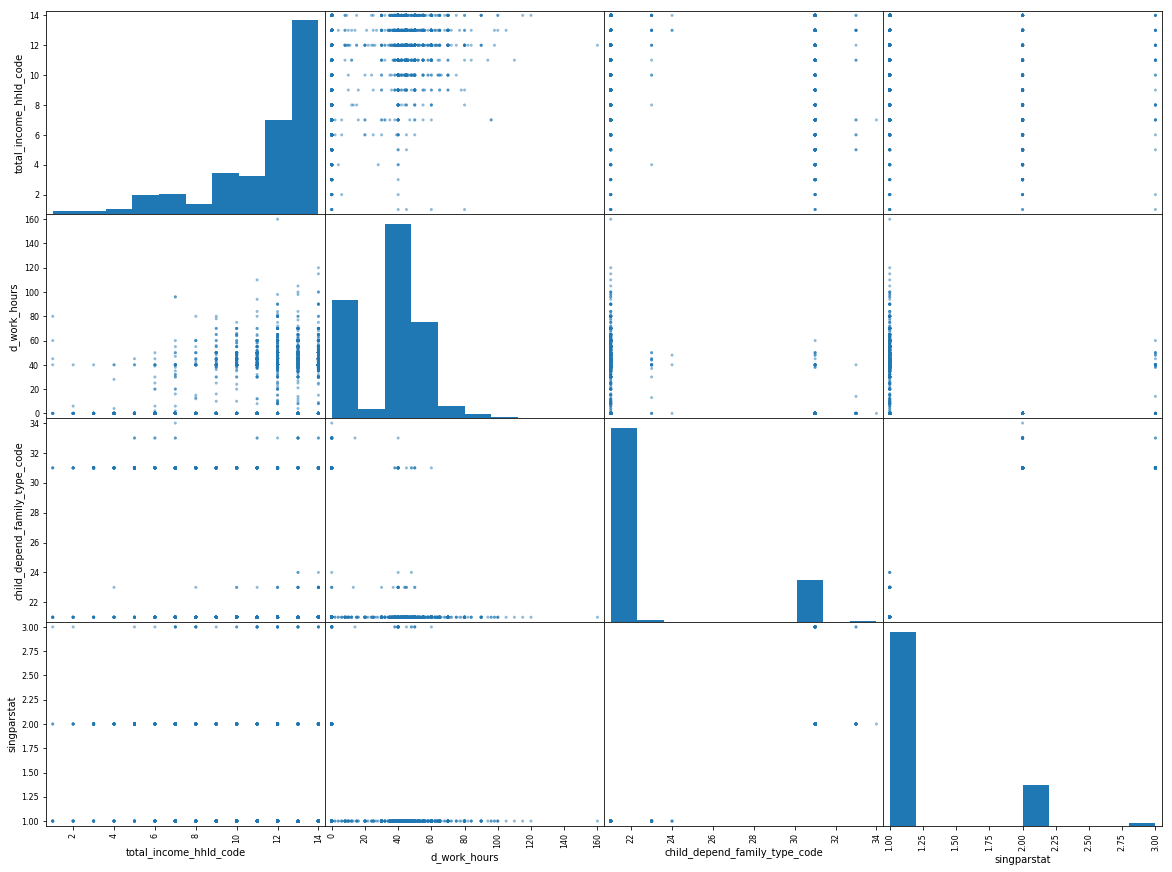

In [471]:
from pandas.plotting import scatter_matrix
attributes = ["total_income_hhld_code", "d_work_hours", "child_depend_family_type_code", "singparstat"]
scatter_matrix(train[attributes], figsize=(20,15))

In [493]:
num_attr = ["m_age", "d_age", "bedroom_count_code", "m_years_at_addr_code", "m_work_hours", "d_years_at_addr_code", "d_work_hours", "usual_resdnt_count_code"]
cat_attr = ['NZDep2006', 'ch_asian', 'ch_euro', 'ch_maori', 'ch_melaa', 'ch_other',
        'ch_pacific', 'ch_sex', 'child_depend_family_type_code', 'd_asian',
        'd_education', 'd_euro', 'd_family_role_code', 'd_income_srce10',
        'd_income_srce11', 'd_income_srce12', 'd_income_srce7',
        'd_income_srce8', 'd_income_srce9', 'd_maori', 'd_melaa', 'd_other',
        'd_pacific', 'd_smoke', 'd_tenure_holder_code', 'd_wklfs_code',
        'heat_fuel', 'm_asian', 'm_education', 'm_euro', 'm_family_role_code',
        'm_income_srce10', 'm_income_srce11', 'm_income_srce12',
        'm_income_srce7', 'm_income_srce8', 'm_income_srce9', 'm_maori',
        'm_melaa', 'm_other', 'm_pacific', 'm_smoke', 'm_tenure_holder_code',
        'm_wklfs_code', 'random_ID', 'singparstat', 'telecomm1_code',
        'telecomm2_code', 'telecomm4_code', 'twin']

In [494]:
num_median = x_train[num_attr].median()
cat_freq = x_train.apply(pd.Series.value_counts).max()
cat_freq
fill_values = pd.concat([num_median, cat_freq])

In [541]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [545]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import Imputer, MinMaxScaler, OneHotEncoder

num_pipeline = Pipeline([
        ('selector',
    DataFrameSelector(num_attr)),
        ('imputer',
    Imputer(strategy="median")),
        ('std_scaler',
    MinMaxScaler()),
])

cat_pipeline = Pipeline([
        ('selector',
    DataFrameSelector(cat_attr)),
        ('imputer',
    Imputer(strategy="most_frequent")),
#         ('cat_encoder',
#     OneHotEncoder())
])

In [546]:
from sklearn.pipeline import FeatureUnion

full_pipeline_train = FeatureUnion(transformer_list=[("num_pipeline", num_pipeline),("cat_pipeline", cat_pipeline),])

In [547]:
full_pipeline_train.fit(x_train)
train_prepared = full_pipeline_train.transform(x_train)
feature_selector = SelectPercentile(chi2, percentile=20).fit(train_prepared, y_train)
train_prepared = feature_selector.transform(train_prepared)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [548]:
test_prepared = full_pipeline_train.transform(x_test)
test_prepared = feature_selector.transform(test_prepared)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [556]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(4)
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier()

In [557]:
from sklearn.model_selection import cross_val_score
cross_val_score(rforest, train_prepared, y_train, cv=10)

C:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.18627451, 0.22295082, 0.19078947, 0.22847682, 0.23255814,
       0.18729097, 0.2147651 , 0.24915825, 0.27027027, 0.21232877])

In [562]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators": [5, 10, 15, 20, 25, 30]}
clf = RandomizedSearchCV(rforest, param_distributions=param_dist,
                                   n_iter=20)
cross_val_score(clf, train_prepared, y_train, cv=5)

array([0.28595041, 0.30016584, 0.34442596, 0.27591973, 0.34232715])